<a href="https://colab.research.google.com/github/KevinTheRainmaker/ML_DL_Basics/blob/master/HonGong_ML_DL/19_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM과 GRU 셀

### **키워드:**  LSTM, 셀 상태, GRU

순환 신경망에서 빼놓을 수 없는 핵심 기술인 LSTM과 GRU 셀을 사용한 모델을 만들어보자.

일반적으로 기본 순환층은 긴 시퀀스를 학습하기 어렵다. 시퀀스가 길수록 순환되는 은닉 상태에 담긴 정보가 점차 희석되기 때문에 멀리 떨어져 있는 단어 정보를 인식하는데 어려움이 있다.

이를 해결하기 위해 LSTM과 GRU 셀이 발명되었다.

In [1]:
# packages

from tensorflow import keras
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## LSTM 구조

LSTM은 Long Shor-Term Memory의 약자로, 단기 기억을 오래 기억하기 위해 고안된 구조이다. LSTM에는 입력과 가중치를 곤하고 절편을 더해 활성화 함수를 통과시키는 구조를 여러 개 가지고 있다. 이런 계산 결과는 다음 타임스텝에 재사용된다.

입력과 이전 타임스텝의 은닉 상태를 가중치에 곱한 후 활성화 함수를 통과시킨 값을 다음 은닉 상태를 만들기 위해 사용한다. 이때 기본 순환층과는 달리 시그모이드 활성화 함수를 사용한다. 여기에 tanh 활성화 함수를 통과한 어떤 값을 곱해 은닉 상태를 만든다. 여기서의 어떤 값은 셀 상태로부터 만들어진 은닉 상태이다.

LSTM에는 순환되는 상태는 은닉 상태와 셀 상태(cell state)로 2개이다. 은닉 상태와 달리 셀 상태는 다음 층으로 전달되지 않고 LSTM 셀에서 순환만 되는 값이다. 입력과 은닉 상태를 첫 번째 가중치와는 다른 가중치에 곱하여 시그모이드 함수를 통과시킨 후 이전 타임스텝의 셀 상태와 곱하여 새로운 셀 상태를 만든다. 이 셀 상태가 tanh 함수를 통과하여 새로운 은닉 상태를 만드는데 기여한다.

여기에 2개의 작은 셀이 더 추가되어 셀 상태를 만드는 데 기여한다. 이전과 마찬가지로 입력과 은닉 상태를 각기 다른 가중치에 곱한 다음, 하나의 시그모이드 함수를 통과시키고 다른 하나는 tanh 함수를 통과시킨다. 그 다음 두 결과를 곱하여 이전 셀 상태와 더하면 최종적인 다음 셀 상태가 된다.

<img src='https://user-images.githubusercontent.com/76294398/147720072-4a3a011f-5ccb-4c83-bc5b-518cc33c5b26.png' width=40% height=80%>


삭제 게이트(forget gate)는 셀 상태에 있는 정보를 제거하는 역할을 하고 입력 게이트(input gate)는 새로운 정보를 셀 상태에 추가한다. 출력 게이트(output gate)를 통해서 이 셀 상태가 다음 은닉 상태로 출력된다.

## LSTM 신경망 훈련하기

In [2]:
# dataset
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=500)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

train_seq = pad_sequences(X_train, maxlen=100)
val_seq = pad_sequences(X_val, maxlen=100)

17473536/17464789 [==============================] - 1s 0us/step


In [3]:
model = keras.Sequential()
model.add(keras.layers.Embedding(500, 16, input_length=100))
model.add(keras.layers.LSTM(8))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           8000      
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 8,809
Trainable params: 8,809
Non-trainable params: 0
_________________________________________________________________


LSTM에는 작은 셀이 4개가 있으므로 SimpleRNN 대비 모델 파라미터 개수가 4배 늘어 800개가 되었다.

In [4]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 12s 22ms/step - loss: 0.6915 - accuracy: 0.5544 - val_loss: 0.6894 - val_accuracy: 0.6174
Epoch 2/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6827 - accuracy: 0.6554 - val_loss: 0.6698 - val_accuracy: 0.6828
Epoch 3/100
313/313 [==============================] - 8s 24ms/step - loss: 0.6266 - accuracy: 0.7035 - val_loss: 0.5926 - val_accuracy: 0.7148
Epoch 4/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5763 - accuracy: 0.7261 - val_loss: 0.5644 - val_accuracy: 0.7320
Epoch 5/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5491 - accuracy: 0.7451 - val_loss: 0.5443 - val_accuracy: 0.7430
Epoch 6/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5272 - accuracy: 0.7583 - val_loss: 0.5267 - val_accuracy: 0.7508
Epoch 7/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5086 - accuracy: 0.7684 - val_loss: 0.5099 - val_accuracy

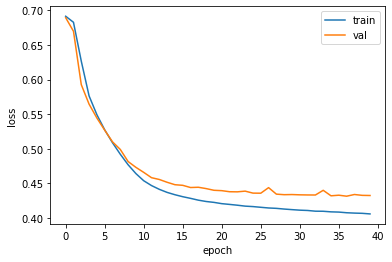

In [5]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

기본 순환층보다 확실히 과대적합을 잘 억제하고 있다. 하지만 경우에 따라서는 더 강하게 억제할 필요가 있다. 드롭아웃으로 이를 수행해보자.

## 순환층에 드롭아웃 적용하기

기존에는 Dropout 클래스를 사용하여 드롭아웃을 적용했다. 반면 순환층은 자체적으로 드롭아웃 기능을 제공한다.

dropout 매개변수는 셀의 입력에 드롭아웃을 적용하고 recurrent_dropout 매개변수는 순환되는 은닉 상태에 드롭아웃을 적용한다.(기술적인 문제로 recurrent_dropout은 GPU를 사용하지 못한다.)

In [6]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(500, 16, input_length=100))
model2.add(keras.layers.LSTM(8, dropout=0.3))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [7]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model2.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model2.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 22ms/step - loss: 0.6921 - accuracy: 0.5464 - val_loss: 0.6912 - val_accuracy: 0.5864
Epoch 2/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6889 - accuracy: 0.6193 - val_loss: 0.6863 - val_accuracy: 0.6440
Epoch 3/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6776 - accuracy: 0.6594 - val_loss: 0.6629 - val_accuracy: 0.6714
Epoch 4/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6187 - accuracy: 0.7078 - val_loss: 0.5977 - val_accuracy: 0.7186
Epoch 5/100
313/313 [==============================] - 6s 20ms/step - loss: 0.5808 - accuracy: 0.7293 - val_loss: 0.5711 - val_accuracy: 0.7352
Epoch 6/100
313/313 [==============================] - 6s 21ms/step - loss: 0.5594 - accuracy: 0.7434 - val_loss: 0.5503 - val_accuracy: 0.7506
Epoch 7/100
313/313 [==============================] - 6s 21ms/step - loss: 0.5418 - accuracy: 0.7534 - val_loss: 0.5320 - val_accuracy:

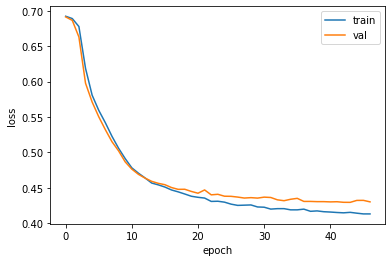

In [8]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

LSTM 층에 적용된 드롭아웃이 효과를 발휘해 훈련 손실과 검증 손실 간 차이가 좁혀졌다.

이번에는 2개의 순환층을 연결한 모델을 훈련해보자.

## 2개의 층 연결하기

순환층의 은닉 상태는 샘플의 마지막 타임스텝에 대한 은닉 상태만 다음 층으로 전달한다. 하지만 순환층을 쌓게 되면 모든 순환층에 순차 데이터가 필요하다. 따라서 앞쪽의 순환층이 모든 타임스텝에 대한 은닉 상태를 출력해야 한다.

케라스의 순환층에서 모든 타임스텝의 은닉 상태를 출력하려면 return_sequences 매개변수를 True로 지정하면 된다.

In [9]:
model3 = keras.Sequential()
model3.add(keras.layers.Embedding(500, 16, input_length=100))
model3.add(keras.layers.LSTM(8, dropout=0.3, return_sequences=True))
model3.add(keras.layers.LSTM(8, dropout=0.3))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           8000      
                                                                 
 lstm_2 (LSTM)               (None, 100, 8)            800       
                                                                 
 lstm_3 (LSTM)               (None, 8)                 544       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 9,353
Trainable params: 9,353
Non-trainable params: 0
_________________________________________________________________


In [10]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model3.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-lstm-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model3.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 18s 45ms/step - loss: 0.6927 - accuracy: 0.5172 - val_loss: 0.6918 - val_accuracy: 0.5894
Epoch 2/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6885 - accuracy: 0.5898 - val_loss: 0.6819 - val_accuracy: 0.6340
Epoch 3/100
313/313 [==============================] - 13s 43ms/step - loss: 0.6511 - accuracy: 0.6489 - val_loss: 0.6061 - val_accuracy: 0.6974
Epoch 4/100
313/313 [==============================] - 13s 43ms/step - loss: 0.5813 - accuracy: 0.7080 - val_loss: 0.5565 - val_accuracy: 0.7352
Epoch 5/100
313/313 [==============================] - 13s 42ms/step - loss: 0.5430 - accuracy: 0.7373 - val_loss: 0.5195 - val_accuracy: 0.7588
Epoch 6/100
313/313 [==============================] - 13s 42ms/step - loss: 0.5178 - accuracy: 0.7556 - val_loss: 0.4976 - val_accuracy: 0.7690
Epoch 7/100
313/313 [==============================] - 13s 42ms/step - loss: 0.5019 - accuracy: 0.7630 - val_loss: 0.4851 - val_ac

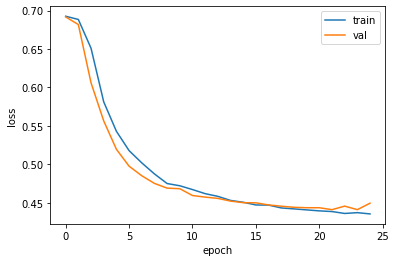

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

비록 여기서는 큰 improve를 보이진 못했지만, 과대적합을 잘 제어하면서 학습을 진행했다.

## GRU 구조

GRU(Gated Recurrent Unit) 셀은 뉴욕 대학교 조경현 교수가 발명한 셀로 유명하다. LSTM의 간소화 버전으로 이해되기도 하는 이 구조는 LSTM과 달리 셀 상태를 계산하지 않고 은닉 상태 하나만을 포함하고 있다.

GRU 셀에는 은닉 상태와 입력에 가중치를 곱하고 절편을 더하는 작은 셀이 3개 들어있다. 2개는 시그모이드 활성화 함수를 사용하고 하나는 tanh 활성화 함수를 사용한다. 

GRU 셀은 LSTM보다 가중치가 적기 때문에 계산량이 적지만 LSTM 못지않은 좋은 성능을 낸다고 알려져 있다.

## GRU 신경망 훈련하기

In [15]:
model4 = keras.Sequential()
model4.add(keras.layers.Embedding(500,16, input_length=100))
model4.add(keras.layers.GRU(8, dropout=0.3))
model4.add(keras.layers.Dense(1, activation='sigmoid'))

In [16]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           8000      
                                                                 
 gru_1 (GRU)                 (None, 8)                 624       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 8,633
Trainable params: 8,633
Non-trainable params: 0
_________________________________________________________________


In [17]:
rmsprop = keras.optimizers.RMSprop(learning_rate=0.0001)
model4.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['accuracy'])

checkpoint_cb = keras.callbacks.ModelCheckpoint('best-gru-model.h5')
early_stopping_cb = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)

history = model4.fit(train_seq, y_train, epochs=100, batch_size=64,
                    validation_data=(val_seq, y_val),
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - 9s 22ms/step - loss: 0.6922 - accuracy: 0.5191 - val_loss: 0.6912 - val_accuracy: 0.5502
Epoch 2/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6904 - accuracy: 0.5526 - val_loss: 0.6895 - val_accuracy: 0.5716
Epoch 3/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6880 - accuracy: 0.5699 - val_loss: 0.6869 - val_accuracy: 0.5868
Epoch 4/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6844 - accuracy: 0.5917 - val_loss: 0.6828 - val_accuracy: 0.5962
Epoch 5/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6790 - accuracy: 0.6064 - val_loss: 0.6765 - val_accuracy: 0.6024
Epoch 6/100
313/313 [==============================] - 6s 21ms/step - loss: 0.6708 - accuracy: 0.6150 - val_loss: 0.6681 - val_accuracy: 0.6162
Epoch 7/100
313/313 [==============================] - 7s 21ms/step - loss: 0.6591 - accuracy: 0.6356 - val_loss: 0.6545 - val_accuracy:

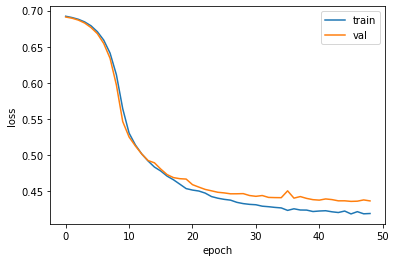

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [20]:
train_seq = pad_sequences(X_test, maxlen=100)
gru_model = keras.models.load_model('best-gru-model.h5')
gru_model.evaluate(val_seq, y_val)

157/157 [==============================] - 2s 8ms/step - loss: 0.4360 - accuracy: 0.7988


[0.4360349476337433, 0.798799991607666]